# Analyzing Flight Prices for Popular US Routes with Evidence from Crude Oil Prices

**Group B8** (alphabetical order)
- Scott Bardwell
- Yiwen Fan
- Yicheng Jiang
- Che Wang
- Xizhi Wang

# Report Summary

This report examines flight data from Expedia and historical oil prices to identify the key factors influencing flight prices. Knowledge of these factors is crucial for various sectors in the travel industry, including airlines for pricing strategy and optimization and consumers/travel agencies for trend analysis. Our data was sourced from Expedia for flight information between major US airports from April to October 2022 and from NYMEX for crude oil prices over the past ten years. Together we used this data to explore the impacts of factors such as total travel distance and the flight day of the week. We also ran various regression models to determine whether we could predict flight prices and isolate which factors were the most impactful. The charts in Section 10 show that the total travel distance is the most significant factor in flight prices. However, additional factors like the oil price and the seats remaining on the flight also have a sizeable contribution to prices. Ultimately, the analysis done in this report has practical applications for airlines to better compete on prices and for consumers to be aware of their purchasing habits. 

# 1.Project Definition

## 1.1 Problem Definition

The objective of this project is to conduct an analysis of flight data to determine the factors that impact the cost of one-way tickets, including the time remaining before departure, the fare class, the refundability of the ticket, whether it is non-stop, and the number of available seats, among other factors. The study will also examine the correlation between crude oil prices and flight prices. 

This project is important because the airline industry is highly competitive, and airlines constantly look for ways to improve their revenue and profitability. Understanding the factors that impact the cost of airline tickets can provide valuable insights for airlines and travel agencies to optimize their pricing strategies and stay ahead of their competitors. Moreover, the correlation between crude oil prices and flight prices is an essential factor for airlines to consider, as fluctuations in crude oil prices can significantly impact their operating costs and, ultimately, their profitability. Therefore, this analysis can aid in developing effective pricing and marketing strategies, leading to increased revenue and profitability for airlines and travel agencies.

## 1.2 Data Source

- Main data

The main data used for this project was obtained from Expedia and pertained to one-way flights taking place between April 16, 2022, and October 5, 2022, to/from major US airports, including ATL, DFW, DEN, ORD, LAX, CLT, MIA, JFK, EWR, SFO, DTW, BOS, PHL, LGA, IAD, OAK. <br>

Data are scraped from https://www.expedia.com/ <br>
Compressed versions of the data: https://github.com/dilwong/FlightPrices <br>
Kaggle link: https://www.kaggle.com/datasets/dilwong/flightprices 

- Secondary data

The secondary data source for this project is the daily closing prices for West Texas Intermediate (NYMEX) Crude Oil in U.S. dollars over the last 10 years.<br>

https://www.macrotrends.net/2516/wti-crude-oil-prices-10-year-daily-chart

## 1.3 Motivation

Understanding the factors that affect flight prices is crucial in the travel industry, and this project presents an opportunity to gain insights into this complex issue. By analyzing this dataset, we can provide valuable information to travel agencies and consumers to help them make informed decisions when booking flights. Three different business perspectives motivate our analysis:

1. **Airlines** will have varying competitive advantages. Whether that is the budget no, thrill airlines like Spirit or easy jet, the expensive and high-end travel experiences like Singapore Airlines, or the airlines like Delta that like to cater to a wide range of customers, pricing strategy is crucial. Knowing what your competitors are doing and how you can strategically price your tickets over the lifecycle of a flight is key to gaining a competitive edge.

2. **Customers** also are very sensitive to changes in flight prices. For example, knowing when the best day to travel or the best month to travel to have the lowest possible airfare is valuable information for consumers.  

3. **Oil Companies** also have a stakeholder interest in flight prices and oil price's impact. As oil can be a volatile commodity, knowing how to balance the scales of oil reserves, futures, and derivates is important in keeping a balanced portfolio that protects these companies against multiple economic scenarios. This is evident by the varying hedging strategies we have seen airlines have with oil companies; some base contracts from current oil prices, while others will leverage calls and put into protecting against future price volatility. 

## 1.4 Limitations

One limitation of the data used for this project is that it only pertains to one-way flights between April 16, 2022, and October 5, 2022, to/from major US airports. This means the data may differ from flight patterns or prices for other types of flights, such as round-trip or international flights. Additionally, the data is limited to a specific set of US airports, which may differ from flight patterns or prices for airports in other countries or regions. Therefore, caution should be exercised when generalizing the findings from this data to different contexts.

# 2.Loading Data

## 2.1 Summary of Key Variables

### 2.1.1 Flight Data

| Column | Description | Null| Data Type | Transformation | 
| -------------|-------------|-----|------------------------|---------------|
| `legId`| An identifier for the flight| No | String | No |
| `searchDate`| The date (YYYY-MM-DD) on which this entry was taken from Expedia | No | Date | No|
| `flightDate`| The date (YYYY-MM-DD) of the flight| No | Date | No|
| `startingAirport`| Three-character IATA airport code for the initial location|  No | Categorical | No
| `destinationAirport`| Three-character IATA airport code for the arrival location | No | Categorical | No
| `travelDuration` | The travel duration in hours and minutes| No | String | <font color ='red'>Yes</font> <br>convert string into integer (in minutes) `travelDurationMin`
| `isBasicEconomy`| Boolean for whether the ticket is for basic economy | No | Boolean | No
| `isRefundable`| Boolean for whether the ticket is refundable| No | Boolean | No
| `isNonStop` | Boolean for whether the flight is non-stop| No | Boolean | No
| `baseFare` | The price of the ticket (in USD)| No | Numerical | No
| `totalFare`| The price of the ticket (in USD) including taxes and other fees| No | Numerical | No
| `seatsRemaining`| Integer for the number of seats remaining |  No | Numerical | No
| `totalTravelDistance`| The total travel distance in miles | <font color ='red'>Yes</font> | Numerical | No


### 2.1.2 Crude Oil Data

| Column | Description | Null| Data Type | Transformation | 
| -------------|-------------|-----|------------------------|---------------|
| `date`| The date (YYYY-MM-DD) of the daily closing price for West Texas Intermediate (NYMEX) Crude Oil | No | Date | No|
| `value`| The daily closing price for West Texas Intermediate (NYMEX) Crude Oil in USD | No | Numerical  | No|

## 2.2 Importing Libraries

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import re
import gc
import os
from pyspark_dist_explore import hist
from io import StringIO
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import numpy as np

from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

plt.style.use('ggplot') 
%matplotlib inline

## 2.3 Defining Schema

In [ ]:
flightSchema = StructType([
    StructField("legId", StringType(), True),
    StructField("searchDate", DateType(), True),
    StructField("flightDate", DateType(), True),
    StructField("startingAirport", StringType(), True),
    StructField("destinationAirport", StringType(), True),
    StructField("fareBasisCode", StringType(), True),
    StructField("travelDuration", StringType(), True),
    StructField("elapsedDays", IntegerType(), True),
    StructField("isBasicEconomy", BooleanType(), True),
    StructField("isRefundable", BooleanType(), True),
    StructField("isNonStop", BooleanType(), True),
    StructField("baseFare", DoubleType(), True),
    StructField("totalFare", DoubleType(), True),
    StructField("seatsRemaining", IntegerType(), True),
    StructField("totalTravelDistance", DoubleType(), True),
    StructField("segmentsDepartureTimeEpochSeconds", StringType(), True),
    StructField("segmentsDepartureTimeRaw", StringType(), True),
    StructField("segmentsArrivalTimeEpochSeconds", StringType(), True),
    StructField("segmentsArrivalTimeRaw", StringType(), True),
    StructField("segmentsArrivalAirportCode", StringType(), True),
    StructField("segmentsDepartureAirportCode", StringType(), True),
    StructField("segmentsAirlineName", StringType(), True),
    StructField("segmentsAirlineCode", StringType(), True),
    StructField("segmentsEquipmentDescription", StringType(), True),
    StructField("segmentsDurationInSeconds", StringType(), True),
    StructField("segmentsDistance", StringType(), True),
    StructField("segmentsCabinCode", StringType(), True)
])

oilSchema = StructType([
  StructField("date", DateType(), True),
  StructField("value", DoubleType(), True)
])

## 2.4 Reading Data

In [ ]:
flight = spark.read.format("csv") \
    .option("header", "true") \
    .schema(flightSchema) \
    .load("gs://team8-cluster/notebooks/jupyter/itineraries.csv")

oil = spark.read.format("csv") \
    .option("header", "true") \
    .schema(oilSchema) \
    .load("gs://team8-cluster/notebooks/jupyter/wti-crude-oil-prices-10-year-daily-chart.csv")

## 2.5 Selecting Columns

In [ ]:
flight = flight.select(
    col('legId'),
    col('searchDate'),
    col('flightDate'),
    col('startingAirport'),
    col('destinationAirport'),
    col('travelDuration'),
    col('isBasicEconomy'),
    col('isRefundable'),
    col('isNonStop'),
    col('baseFare'),
    col('totalFare'),
    col('seatsRemaining'),
    col('totalTravelDistance')
)

flight.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: double (nullable = true)



## 2.6 Joining Tables 

In [ ]:
# Extract the year and month information from two tables
flight_df = flight.withColumn("yearMonth", concat_ws("", year("flightDate"), month("flightDate")))
oil_df = oil.withColumn("yearMonth", concat_ws("", year("date"), month("date")))

# Compute the mean value of value for each YearMonth in oil_df
oil_mean_df = oil_df.groupBy("yearMonth") \
    .agg(avg("value").alias("oilPriceAvg"))

# Join the flight and oil data using YearMonth
df = flight_df.join(oil_mean_df, "yearMonth")

In [ ]:
df.printSchema()
df = df.select('legId', 'searchDate', 'flightDate', 'startingAirport', 'destinationAirport', 
               'travelDuration', 'isBasicEconomy', 'isRefundable', 'isNonStop', 'baseFare', 'totalFare', 
               'seatsRemaining', 'totalTravelDistance', 'yearMonth', 'oilPriceAvg')
df.show(3)

root
 |-- yearMonth: string (nullable = false)
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: double (nullable = true)
 |-- oilPriceAvg: double (nullable = true)



+--------------------+----------+----------+---------------+------------------+--------------+--------------+------------+---------+--------+---------+--------------+-------------------+---------+------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|travelDuration|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|yearMonth|       oilPriceAvg|
+--------------------+----------+----------+---------------+------------------+--------------+--------------+------------+---------+--------+---------+--------------+-------------------+---------+------------------+
|9ca0e81111c683bec...|2022-04-16|2022-04-17|            ATL|               BOS|       PT2H29M|         false|       false|     true|  217.67|    248.6|             9|              947.0|    20224|101.84057142857141|
|98685953630e772a0...|2022-04-16|2022-04-17|            ATL|               BOS|       PT2H30M|         false|       false|     true|  21

# 3. Data Cleaning

## 3.1 Duplicate Records

In [ ]:
if df.count() == df.dropDuplicates().count():
    print('Data has no duplicates')
else:
    print('Warning: Data may have duplicates')

Data has no duplicates


## 3.2 Coloumn `travelDuration` transformation 

In [ ]:
def duration_to_minutes(duration_str):
    """
    the original format of the duration is a set of strange strings,
    we use this function to turn them into numbers of minutes (int).
    # this function is created with the help of chatgpt
    # GPT-3 is described in the following publication:
    # Title: Language Models are Few-Shot Learners
    # Authors: Tom B. Brown, Benjamin Mann, Nick Ryder, et al.
    # Link: https://arxiv.org/abs/2005.14165
    """
    match = re.match(r'P(?:(?P<days>\d+)D)?(?:T(?:(?P<hours>\d+)H)?(?:(?P<minutes>\d+)M)?)?', duration_str)
    if match:
        days = int(match.group("days") or 0)
        hours = int(match.group("hours") or 0)
        minutes = int(match.group("minutes") or 0)
        return days * 1440 + hours * 60 + minutes
    else:
        return None

duration_to_minutes_udf = F.udf(duration_to_minutes, IntegerType())
df = df.withColumn("travelDurationMin", duration_to_minutes_udf(F.col("travelDuration")))
df = df.select('legId', 'searchDate', 'flightDate', 'startingAirport', 'destinationAirport', "travelDuration",
               'travelDurationMin', 'isBasicEconomy', 'isRefundable', 'isNonStop', 'baseFare', 'totalFare', 
               'seatsRemaining', 'totalTravelDistance', 'yearMonth', 'oilPriceAvg')
df.show(3)

+--------------------+----------+----------+---------------+------------------+--------------+-----------------+--------------+------------+---------+--------+---------+--------------+-------------------+---------+------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|travelDuration|travelDurationMin|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|yearMonth|       oilPriceAvg|
+--------------------+----------+----------+---------------+------------------+--------------+-----------------+--------------+------------+---------+--------+---------+--------------+-------------------+---------+------------------+
|9ca0e81111c683bec...|2022-04-16|2022-04-17|            ATL|               BOS|       PT2H29M|              149|         false|       false|     true|  217.67|    248.6|             9|              947.0|    20224|101.84057142857141|
|98685953630e772a0...|2022-04-16|2022-04-17|            ATL|    

## 3.2 Null Check

### 3.2.1 Checking percentage of null values

In [ ]:
# Select columns to check for null values
df_null_check = df.select(
    col('travelDurationMin'),
    col('baseFare'),
    col('totalFare'),
    col('seatsRemaining'),
    col('totalTravelDistance'),
    col('yearMonth'),
    col('oilPriceAvg')
)

null_counts = df_null_check.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df_null_check.columns])

null_percentages = null_counts.select([((col(c) / df.count()) * 100).alias(c + '_null_percentage') for c in null_counts.columns])

null_percentages.show()

+---------------------------------+------------------------+-------------------------+------------------------------+-----------------------------------+-------------------------+---------------------------+
|travelDurationMin_null_percentage|baseFare_null_percentage|totalFare_null_percentage|seatsRemaining_null_percentage|totalTravelDistance_null_percentage|yearMonth_null_percentage|oilPriceAvg_null_percentage|
+---------------------------------+------------------------+-------------------------+------------------------------+-----------------------------------+-------------------------+---------------------------+
|                              0.0|                     0.0|                      0.0|                           0.0|                  7.419800979934527|                      0.0|                        0.0|
+---------------------------------+------------------------+-------------------------+------------------------------+-----------------------------------+---------------

### 3.2.2 Checking `totalTravelDistance`

After discovering that the `totalTravelDistance` column contains null values, we inspected the first 10 rows of the dataframe and found that all of the null values were associated with the `startingAirport` value of "ATL". 

To investigate further, we grouped the dataframe by `startingAirport` and examined the null values in `totalTravelDistance` for each group.

In [ ]:
null_totalTravelDistance = df.filter(col('totalTravelDistance').isNull())
null_totalTravelDistance.show(5)

+--------------------+----------+----------+---------------+------------------+--------------+-----------------+--------------+------------+---------+--------+---------+--------------+-------------------+---------+------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|travelDuration|travelDurationMin|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|yearMonth|       oilPriceAvg|
+--------------------+----------+----------+---------------+------------------+--------------+-----------------+--------------+------------+---------+--------+---------+--------------+-------------------+---------+------------------+
|cb345693479e84838...|2022-04-16|2022-04-17|            ATL|               BOS|       PT5H39M|              339|         false|       false|    false|   183.0|   290.58|             0|               null|    20224|101.84057142857141|
|912ef0fbca3f88a86...|2022-04-16|2022-04-17|            ATL|    

In [ ]:
df.groupBy("startingAirport") \
  .agg(round(avg(col("totalTravelDistance").isNull().cast("int")) * 100, 2).alias("null_percentage"), 
       sum(col("totalTravelDistance").isNull().cast("int")).alias("null_count")) \
  .show()

+---------------+---------------+----------+
|startingAirport|null_percentage|null_count|
+---------------+---------------+----------+
|            OAK|          12.62|    480842|
|            LGA|           4.42|    261772|
|            BOS|           4.08|    240326|
|            EWR|          12.32|    489258|
|            DEN|           4.93|    231731|
|            IAD|            1.2|     41520|
|            CLT|           4.58|    251648|
|            MIA|           9.53|    469942|
|            DFW|          11.03|    625793|
|            SFO|           1.86|    106312|
|            ATL|          12.98|    689398|
|            ORD|           9.01|    495832|
|            DTW|          10.92|    496521|
|            LAX|          10.12|    817131|
|            JFK|           0.92|     40602|
|            PHL|           7.53|    355904|
+---------------+---------------+----------+



Based on the observation, dropping the rows containing null in `totalTravelDistance` is reasonable. This is because the null values seem to be distributed randomly across different starting airports. This means there is no pattern or correlation between the null values and any other feature in the dataset. 

Additionally, the percentage of null values in `totalTravelDistance` for each starting airport is not very high (ranging from 0.92% to 12.98%), so dropping these rows is not likely to significantly affect the analysis. 

Overall, dropping the rows containing null values in `totalTravelDistance` allows us to work with complete data and avoids potential issues in the analysis that could result from imputing missing values.

## 3.3 Dropping `travelDuration` and Missing Values in `totalTravelDistance` 

In [ ]:
df = df.drop("travelDuration")
df = df.dropna(subset=['totalTravelDistance'])

## 3.4 Caching

In [ ]:
df.cache()
df.count()

76044221

In [ ]:
df.show(3)

+--------------------+----------+----------+---------------+------------------+-----------------+--------------+------------+---------+--------+---------+--------------+-------------------+---------+------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|travelDurationMin|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|yearMonth|       oilPriceAvg|
+--------------------+----------+----------+---------------+------------------+-----------------+--------------+------------+---------+--------+---------+--------------+-------------------+---------+------------------+
|9ca0e81111c683bec...|2022-04-16|2022-04-17|            ATL|               BOS|              149|         false|       false|     true|  217.67|    248.6|             9|              947.0|    20224|101.84057142857141|
|98685953630e772a0...|2022-04-16|2022-04-17|            ATL|               BOS|              150|         false|       false

# 4. Exploratory Data Analysis (EDA)

## 4.1 `startingAirport`

### 4.1.1 From April to November in 2022, which airport has the most departure, and how many flight depart from that airport?

LAX had the highest number of departures in 2022 between April and November, with a total of 7,256,150 flights departing from the airport. Following closely behind was LGA airport in New York, with a total of 5,657,551 departures during the same time period. BOS airport also ranked high in terms of number of departures.

In [ ]:
# Create a temporary view of the DataFrame
df.createOrReplaceTempView("dfTable")

23/04/24 17:26:09 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
# Run the SQL query 
start_df = spark.sql("""
SELECT startingAirport, count(startingAirport) as startCount
FROM dfTable
GROUP BY startingAirport
ORDER BY startCount DESC
""")
start_df.show(5)

+---------------+----------+
|startingAirport|startCount|
+---------------+----------+
|            LAX|   7256150|
|            LGA|   5657551|
|            BOS|   5643550|
|            SFO|   5600170|
|            CLT|   5242862|
+---------------+----------+
only showing top 5 rows



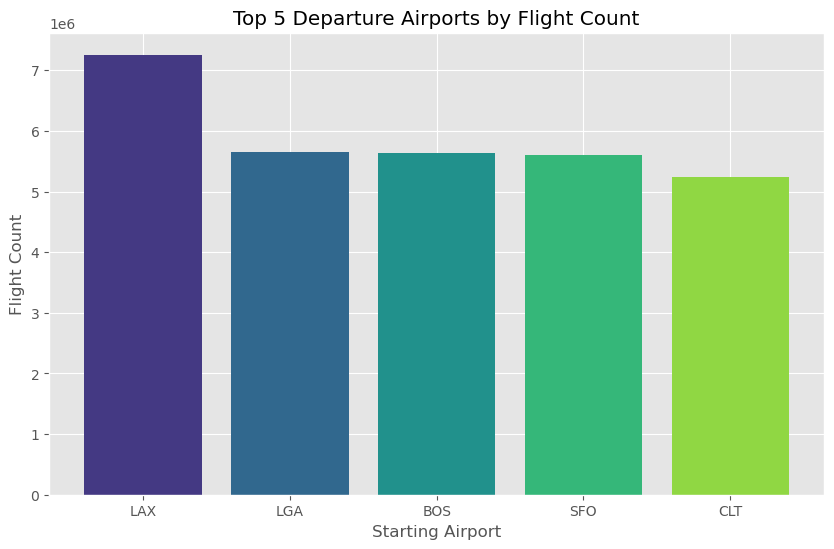

In [ ]:
# Convert the result DataFrame to a Pandas DataFrame for plotting with Matplotlib
start_pd = start_df.limit(5).toPandas()

# Set the color palette
colors = sns.color_palette('viridis', len(start_pd))

# Create a Matplotlib bar chart of the top 5 starting airports by frequency
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(start_pd['startingAirport'], start_pd['startCount'], color=colors)

# Update the layout of the plot to include axis labels and a title
ax.set_xlabel('Starting Airport')
ax.set_ylabel('Flight Count')
ax.set_title('Top 5 Departure Airports by Flight Count')

plt.show()

## 4.2 `destinationAirport`

### 4.2.1 What are the top 3 airports with the highest number of flight arrivals between April and November 2022, and how many flights arrived at the airport with the most arrivals?

According to the data, the top 3 airports with the highest number of flight arrivals are LAX, LGA, and DFW. LAX has the most arrivals, with a total of 7,136,539 flights arriving at the airport between April and November 2022.

In [ ]:
# Run the SQL query 
des_df = spark.sql("""
SELECT destinationAirport, count(destinationAirport) as desCount
FROM dfTable
GROUP BY destinationAirport
ORDER BY desCount DESC
""")
des_df.show(5)

+------------------+--------+
|destinationAirport|desCount|
+------------------+--------+
|               LAX| 7136539|
|               LGA| 5844903|
|               BOS| 5548206|
|               SFO| 5494060|
|               DFW| 5246976|
+------------------+--------+
only showing top 5 rows



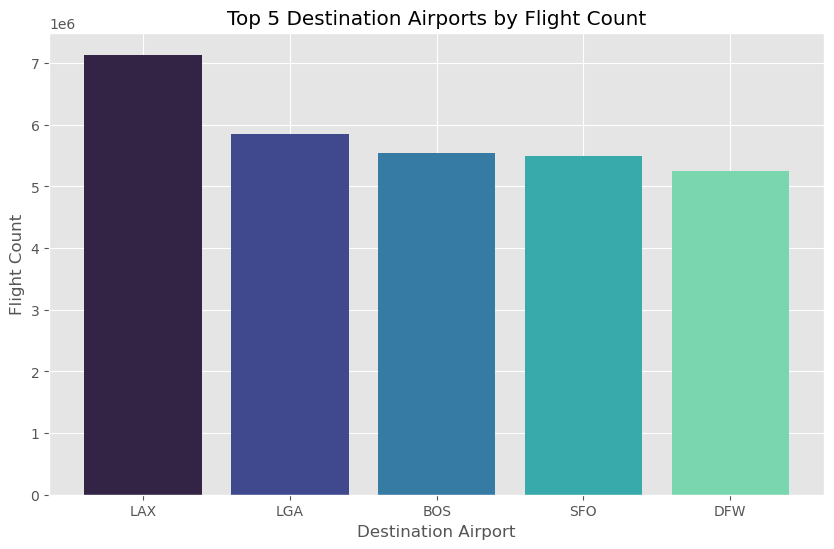

In [ ]:
# Convert the result DataFrame to a Pandas DataFrame for plotting with Matplotlib
des_pd = des_df.limit(5).toPandas()

# Set the color palette
colors = sns.color_palette('mako', len(start_pd))

# Create a Matplotlib bar chart of the top 5 starting airports by frequency
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(des_pd['destinationAirport'], des_pd['desCount'], color=colors)

# Update the layout of the plot to include axis labels and a title
ax.set_xlabel('Destination Airport')
ax.set_ylabel('Flight Count')
ax.set_title('Top 5 Destination Airports by Flight Count')

plt.show()

## 4.3 Month of Flight

### 4.3.1 Which month has the most number of flights during Apirl 2022 to Novermber 2022?

During the summer of 2022, there was a significant increase in the number of flights, which could be caused by the lifting of COVID travel-restrictions or a higher frequency of travel during summer. However, at the beginning of 2022, the number of flights was relatively low due to the COVID pandemic and related travel restrictions. Overall, August has the highest number of flight counts in 2022.

In [ ]:
df.groupBy(year('flightDate').alias('flightYear'), month('flightDate').alias('flightMonth')) \
    .agg(count('*').alias('total_num_flight')) \
    .where((year('flightDate') == 2022) & (month('flightDate') >= 4) & (month('flightDate') <= 11)) \
    .orderBy('total_num_flight', ascending=False) \
    .show()

+----------+-----------+----------------+
|flightYear|flightMonth|total_num_flight|
+----------+-----------+----------------+
|      2022|          8|        16361930|
|      2022|          9|        16192843|
|      2022|          7|        12275593|
|      2022|          6|        10797713|
|      2022|         10|        10291615|
|      2022|          5|         6932022|
|      2022|         11|         2321721|
|      2022|          4|          870784|
+----------+-----------+----------------+



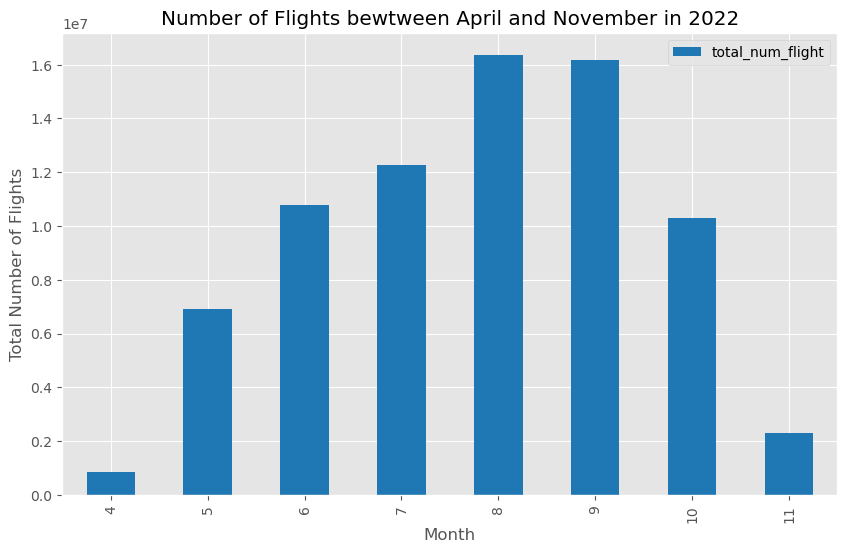

In [ ]:
flight_count_df = df.groupBy(year('flightDate').alias('flightYear'), month('flightDate').alias('flightMonth')) \
                  .agg(count('*').alias('total_num_flight')) \
                  .where((year('flightDate') == 2022) & (month('flightDate') >= 4) & (month('flightDate') <= 11)) \
                  .orderBy('flightMonth', ascending=True) \
                  .toPandas()


flight_count_df.plot(x='flightMonth', y='total_num_flight', kind='bar', color='#1f77b4',figsize=(10, 6))

plt.title('Number of Flights bewtween April and November in 2022')
plt.xlabel('Month')
plt.ylabel('Total Number of Flights')
plt.show()

### 4.3.2 Which month has the highest base (total) fare? Which month has the cheapest base (total) fare? 

In this chart, we can see that the most expensive months to fly are in June and July. However, it is important to note that because our data is only for a 6 month period between April and October, the November data is not complete. Based on the knowledge that Thanksgiving travel tends to be very expensive, we would expect the November month to be more expensive than visually illustrated by our data.

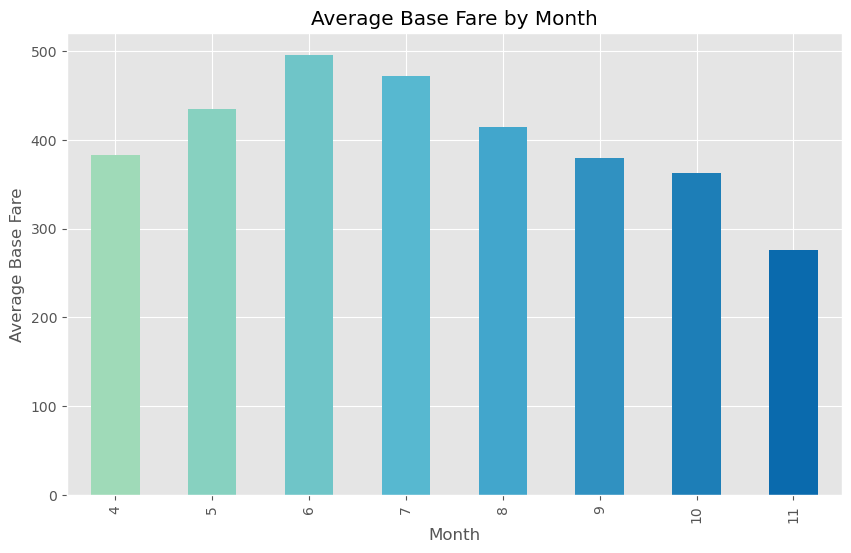

In [ ]:
# group the dataframe by month and legID, and find the maximum baseFare for each legID
max_fares = (
    df
    .groupBy(df['legId'], F.month('flightDate').alias('month'))
    .agg(F.max('baseFare').alias('max_fare'))
)

# join the max_fares dataframe with the original dataframe to get the corresponding rows
flight_with_max_fares = (
    df
    .join(
        max_fares,
        (df['legId'] == max_fares['legId']) & (F.month('flightDate') == max_fares['month']) & (df['baseFare'] == max_fares['max_fare']),
        'inner'
    )
    .dropDuplicates(['legId', 'flightDate'])
)

# group the original dataframe by month and calculate the average baseFare
avg_fares = (
    flight_with_max_fares
    .groupBy(F.month('flightDate').alias('month'))
    .agg(F.mean('baseFare').alias('avg_fare'))
    .orderBy('month')
)

# check if avg_fares is not None before calling toPandas()
if avg_fares is not None:
    # convert to pandas DataFrame and plot the graph
    pd_avg_fares = avg_fares.toPandas()
    pd_avg_fares.plot.bar(x='month', y='avg_fare', figsize=(10, 6), color=plt.cm.GnBu(np.linspace(0.4, 1, 10)),legend=False)
    plt.xlabel('Month')
    plt.ylabel('Average Base Fare')
    plt.title('Average Base Fare by Month')
    plt.show()
else:
    print("avg_fares DataFrame is None")

## 4.4 `travelDuration`

### 4.4.1 What is the summary statistics of travel duration?

The summary statistics calculation reveals that the minimum travel duration is 46 minutes, while the majority of travel durations fall between 250 and 500 minutes, as evidenced by the median value of 399 and the third quartile (Q3) of 553 minutes. Although there are some outliers, such as the maximum travel duration of 1807 minutes, they are unlikely to have a significant impact on our analysis.

In [ ]:
#calculate summary statistics with sql
tmp_query = """
SELECT
    MIN(travelDurationMin) as min,
    PERCENTILE(travelDurationMin, 0.25) as Q1,
    PERCENTILE(travelDurationMin, 0.5) as median,
    PERCENTILE(travelDurationMin, 0.75) as Q3,
    MAX(travelDurationMin) as max,
    AVG(travelDurationMin) as mean
FROM dfTable
"""

# Execute the SQL query and display the results
summary_stats = spark.sql(tmp_query)
summary_stats.show()

+---+-----+------+-----+----+------------------+
|min|   Q1|median|   Q3| max|              mean|
+---+-----+------+-----+----+------------------+
| 46|255.0| 399.0|553.0|1807|419.00389529928907|
+---+-----+------+-----+----+------------------+



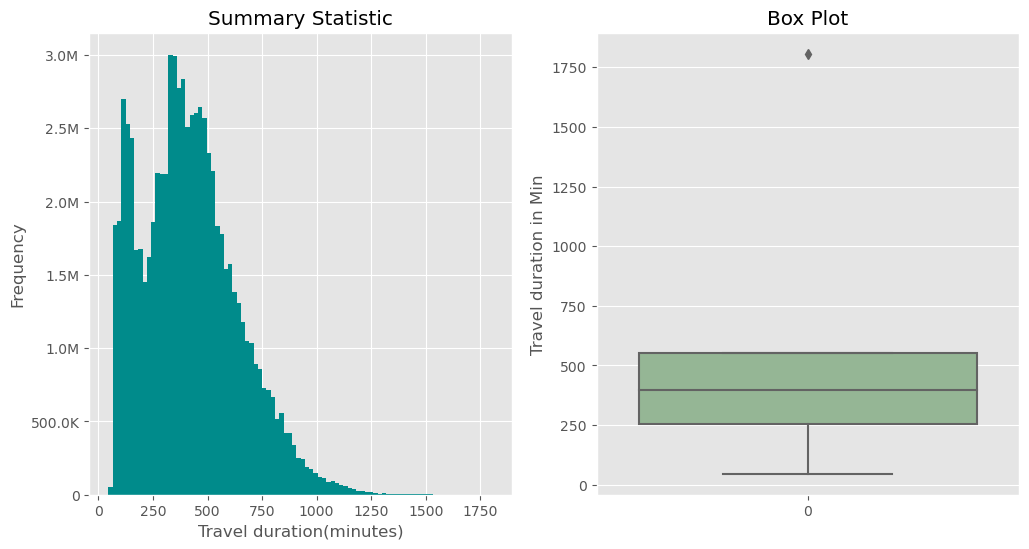

In [ ]:
# parameters
hist_col = "travelDurationMin"
bin_count = 90

# hist_data = df.select(hist_col).rdd.flatMap(lambda x: x).histogram(bin_count)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# create the histogram using pyspark_dist_explore
hist(axes[0], df.select(hist_col), bins=bin_count, color="darkcyan")
axes[0].set_title("Summary Statistic")
axes[0].set_xlabel("Travel duration(minutes)")
axes[0].set_ylabel("Frequency")

# using pre-calculated statistics
stats = summary_stats.collect()[0]
min_val = stats['min']
q1 = stats['Q1']
median = stats['median']
q3 = stats['Q3']
max_val = stats['max']

# create the box plot
sns.boxplot(data=[min_val, q1, median, q3, max_val], ax=axes[1], color="darkseagreen")
axes[1].set_title("Box Plot")
axes[1].set_ylabel("Travel duration in Min")

plt.show()

### 4.4.2 What is the relationship between average fares and travelDuration?

We can observe from the graph below that as travel duration increases, there is a growing trend in the average base fare. However, when the duration exceeds 1000 minutes, the average base fare shows more significant fluctuations.

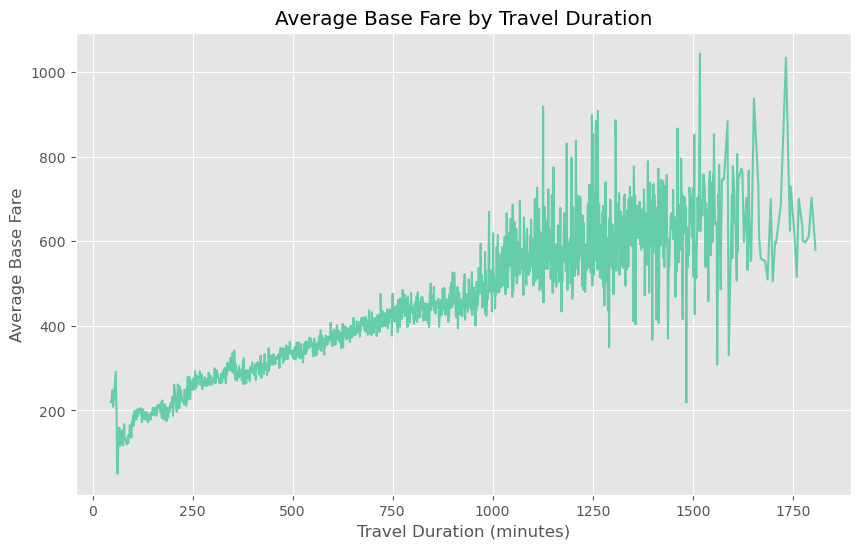

In [ ]:
# group the dataframe by travel duration and calculate the average baseFare
avg_fares_by_duration = (
    df
    .groupBy('travelDurationMin')
    .agg(F.mean('baseFare').alias('avg_fare'))
    .orderBy('travelDurationMin')
)

# convert to pandas DataFrame and plot the graph
pd_avg_fares_by_duration = avg_fares_by_duration.toPandas()
pd_avg_fares_by_duration.plot(x='travelDurationMin', y='avg_fare', figsize=(10, 6), color='mediumaquamarine', legend=False)
plt.xlabel('Travel Duration (minutes)')
plt.ylabel('Average Base Fare')
plt.title('Average Base Fare by Travel Duration')
plt.show()

## 4.5 `isBasicEconomy`

### 4.5.1 What is the percentage of the isBasicEconomy tickets across all tickets in 2022 (April to November)?

Only 15% is Basic Economy tickets across all tickets in 2022 (April to November).

In [ ]:
isBasicEconomy = df.filter(col("isBasicEconomy") == True).count()
total_flights = df.count()

percent = isBasicEconomy/total_flights * 100

print(percent)

15.469037417057635


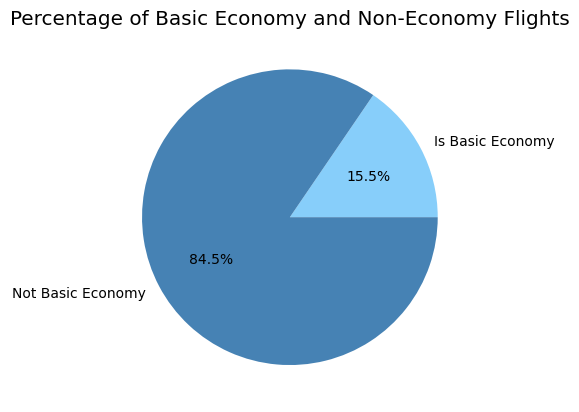

In [ ]:
# count
true_count = df.filter(df.isBasicEconomy == True).count()
false_count = df.filter(df.isBasicEconomy == False).count()

# Calculate the percentage of True and False 
total_count = true_count + false_count
true_percent = true_count / total_count * 100
false_percent = false_count / total_count * 100

# Plot 
labels = ['Is Basic Economy', 'Not Basic Economy']
values = [true_count, false_count]
colors = ['#87CEFA','#4682B4'] # using shades of blue for colors
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title('Percentage of Basic Economy and Non-Economy Flights')
plt.show()

## 4.6 `isNonStop`

### 4.6.1 What are the percentage of non-Stop flights and with stop flights?

Non-stop flights make up 28% of the total flights while flights with stops make up 72%. This observation suggests that most flights in the data set have at least one stop on their routes.

In [ ]:
# Count
true_count = df.filter(df.isNonStop == True).count()
false_count = df.filter(df.isNonStop == False).count()

# Create DataFrame to show count and percentage
count_df = spark.createDataFrame([(true_count, false_count, true_count/(true_count+false_count)*100, false_count/(true_count+false_count)*100)], 
                                 ["Non-Stop Count (True)", "With Stop Count", "Non-Stop Percentage", "With Stop Percentage"])
count_df.show()

+---------------------+---------------+-------------------+--------------------+
|Non-Stop Count (True)|With Stop Count|Non-Stop Percentage|With Stop Percentage|
+---------------------+---------------+-------------------+--------------------+
|             21213669|       54830552| 27.896490648513577|   72.10350935148642|
+---------------------+---------------+-------------------+--------------------+



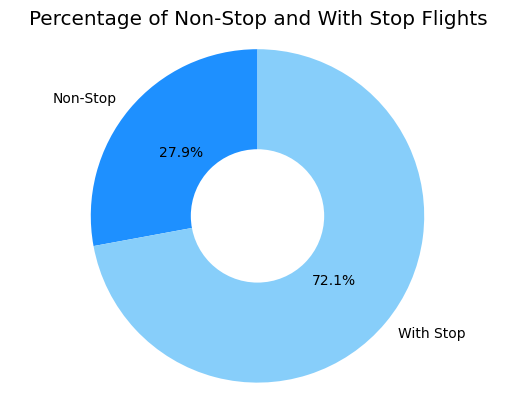

In [ ]:
#Calculate the percentage of True and False

total_count = true_count + false_count
true_percent = true_count / total_count * 100
false_percent = false_count / total_count * 100

labels = ['Non-Stop', 'With Stop']
values = [true_count, false_count]

#Create a donut chart with green color scheme
fig, ax = plt.subplots()
ax.pie(values, labels=labels, colors=['dodgerblue','lightskyblue'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.set_title('Percentage of Non-Stop and With Stop Flights')

#Create a circle to make a donut chart

centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()

## 4.7 `seatsRemaining`

### 4.7.1 What is the average base fare and total fare for each number of seats remaining?

There are two interesting findings from the plotted graph. The first finding indicates that the ticket prices are still available on Expedia even when the remaining seats are zero. This may be due to airlines' tendency to oversell tickets to counter cancellations and maximize profits. The second finding suggests no significant increase in ticket prices within the last ten seats.

In [ ]:
seat_results = spark.sql("SELECT seatsRemaining, AVG(basefare), AVG(totalfare) \
                     FROM dfTable \
                     GROUP BY seatsRemaining \
                     ORDER BY seatsRemaining DESC")

# Display the results
seat_results.show()

+--------------+-----------------+------------------+
|seatsRemaining|    avg(basefare)|    avg(totalfare)|
+--------------+-----------------+------------------+
|            10|284.3477577800935| 325.8483017740686|
|             9|300.0060327299614|344.84588256412445|
|             8|358.1306820270643|408.04694450940116|
|             7|278.0308353569965|  320.299450974918|
|             6|340.5062879727705| 389.0617531983766|
|             5|339.9422624683638| 388.5616515843736|
|             4|297.7111164492647|342.75252625223413|
|             3|344.2280040874949| 393.5585486735291|
|             2|344.1993774027765|393.45539786843176|
|             1|350.5643832878552| 400.3637833820791|
|             0|258.9248081841432| 315.4971867007674|
+--------------+-----------------+------------------+



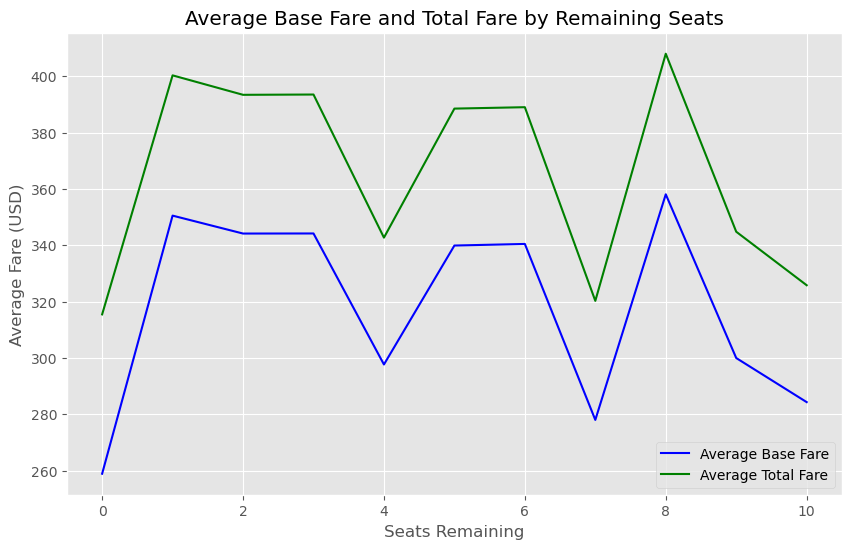

In [ ]:
df_seat = spark.sql("SELECT seatsRemaining, AVG(basefare) AS avg_basefare, AVG(totalfare) AS avg_totalfare \
                FROM dfTable \
                GROUP BY seatsRemaining \
                ORDER BY seatsRemaining")

# Convert Spark DataFrame to Pandas DataFrame
df_seat_pd = df_seat.toPandas()

# Create line plot using seaborn
plt.figure(figsize=(10, 6))
plt.plot(df_seat_pd["seatsRemaining"], df_seat_pd["avg_basefare"], color="blue", label="Average Base Fare")
plt.plot(df_seat_pd["seatsRemaining"], df_seat_pd["avg_totalfare"], color="green", label="Average Total Fare")
plt.title("Average Base Fare and Total Fare by Remaining Seats")
plt.xlabel("Seats Remaining")
plt.ylabel("Average Fare (USD)")
plt.legend()
plt.show()

## 4.8 `totalTravelDistance`

### 4.8.1 What is the relationship between average fares and flight distance ranges?

The below graphs demonstrate a positive correlation between flight distance and fares, as we can see an increasing trend in both the average base and total fares as the distance increases. This suggests that airlines may charge higher prices for longer flights, possibly due to factors such as increased fuel costs or demand for longer flights.

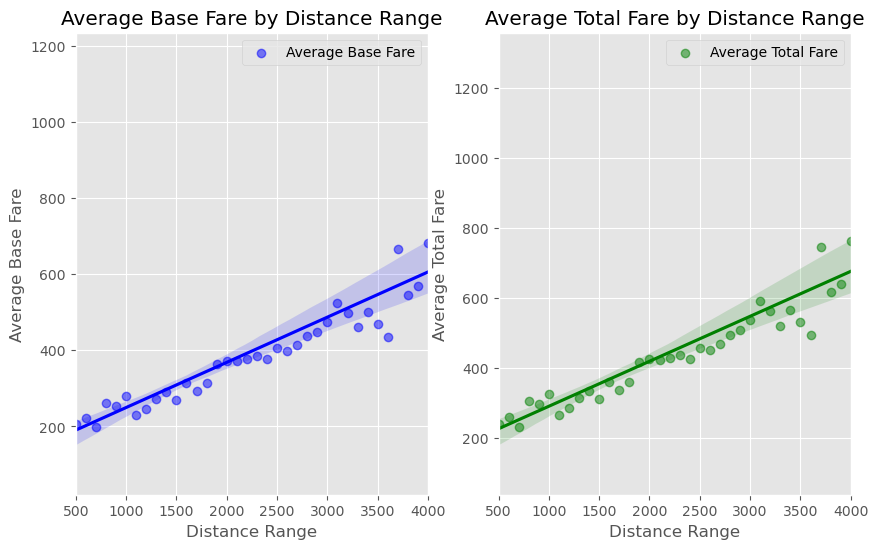

In [ ]:
# Group the data based on the rounded value of totalTravelDistance to the nearest hundred
dis = spark.sql("SELECT (FLOOR(totalTravelDistance/100)*100) AS Distance_Range, AVG(basefare) AS Avg_base_Fare, AVG(totalFare) AS Avg_total_Fare \
                FROM dfTable \
                GROUP BY FLOOR(totalTravelDistance/100) \
                ORDER BY Distance_Range DESC")

distance_ranges = [row.Distance_Range for row in dis.collect()]
avg_base_fares = [row.Avg_base_Fare for row in dis.collect()]
avg_total_fares = [row.Avg_total_Fare for row in dis.collect()]

# Create a scatter plot with regression lines
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
sns.regplot(x=distance_ranges, y=avg_base_fares, ax=ax1, color='b', label='Average Base Fare', scatter_kws={"alpha": 0.5})
sns.regplot(x=distance_ranges, y=avg_total_fares, ax=ax2, color='g', label='Average Total Fare', scatter_kws={"alpha": 0.5})
ax1.legend()
ax2.legend()
ax1.set_xlabel('Distance Range')
ax1.set_ylabel('Average Base Fare')
ax2.set_xlabel('Distance Range')
ax2.set_ylabel('Average Total Fare')
ax1.set_title('Average Base Fare by Distance Range')
ax2.set_title('Average Total Fare by Distance Range')
ax1.set_xlim([500, 4000])
ax2.set_xlim([500, 4000])
plt.show()

## 4.9 `flightDate` & `searchDate`

### 4.9.1 What is the cheapest day of the week to purchase an airline ticket?

The graph below indicates that flights on weekdays are typically less expensive than those on weekends, with Thursday and Wednesday flights being the most affordable.

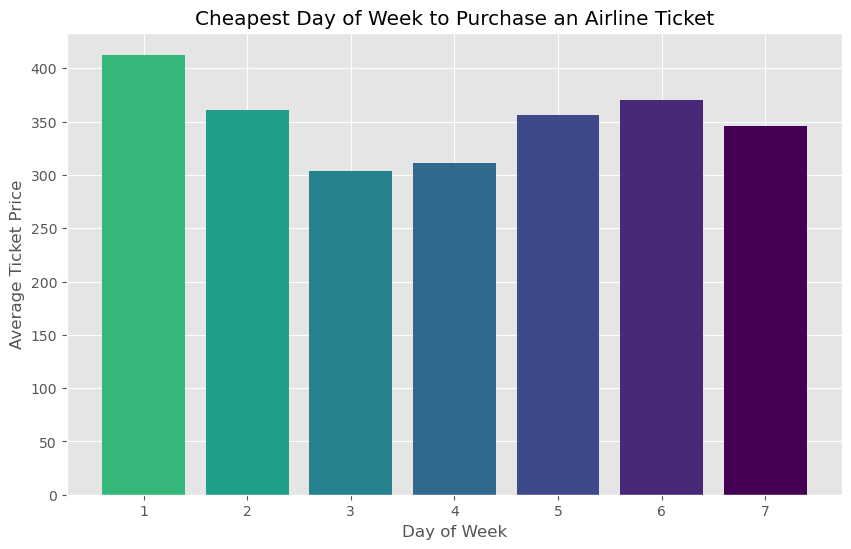

In [ ]:
# Creating the Bar Graph of avg fare price

FlightDayOfWeek = spark.sql("""
SELECT dayofweek(flightDate) as flight_dayofweek, avg(totalFare) as avg_fare_price
FROM dfTable
GROUP BY flight_dayofweek
ORDER BY flight_dayofweek DESC
""")

# Convert Spark DataFrame to Pandas DataFrame
FlightDayOfWeek_pd = FlightDayOfWeek.toPandas()

Day = FlightDayOfWeek_pd['flight_dayofweek']
Price = FlightDayOfWeek_pd['avg_fare_price']
                    
fig = plt.figure(figsize =(10, 6))
 
# Horizontal Bar Plot
plt.bar(Day[0:10], Price[0:10], color=plt.cm.viridis(np.linspace(0, 1, 10)))
plt.xlabel("Day of Week")
plt.ylabel("Average Ticket Price")
plt.title("Cheapest Day of Week to Purchase an Airline Ticket")

# Show Plot
plt.show()

Note: 1=Sunday, 2=Monday, 3=Tuesday, 4=Wednesday, 5=Thursday, 6=Friday, 7=Saturday

### 4.9.2 How does the average fare price vary by day of the week for flights booked on the search date versus the flight date?

This chart shows the average ticket price per both the day of the week of searching for a flight ticket as well as the actual flight date. As we can see from the orange bar, flying out on Sunday is the most expensive date, while Tuesday and Wednesday are on average the cheapest. While it does not appear that there is much difference on the day to search for and buy a ticket, Sunday is marginally a cheaper search date.

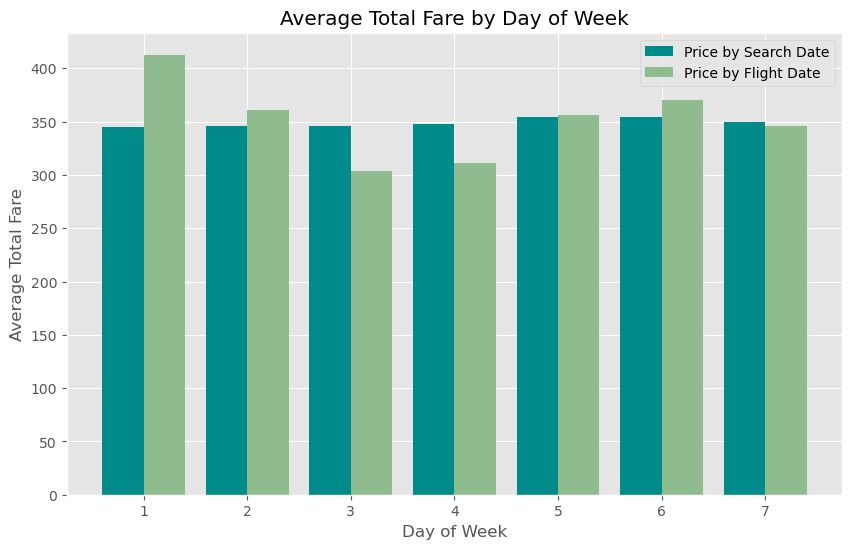

In [ ]:
import matplotlib.pyplot as plt

# Query 
search_query = """
SELECT dayofweek(searchDate) as day_of_week, avg(totalFare) as avg_fare_price
FROM dfTable
GROUP BY day_of_week
ORDER BY day_of_week
"""

flight_query = """
SELECT dayofweek(flightDate) as day_of_week, avg(totalFare) as avg_fare_price
FROM dfTable
GROUP BY day_of_week
ORDER BY day_of_week
"""

# Create Pandas dataframes from the query results
search_df = spark.sql(search_query).toPandas()
flight_df = spark.sql(flight_query).toPandas()

# Plot the data using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(search_df['day_of_week'] - 0.2, search_df['avg_fare_price'], width=0.4, label='Price by Search Date', color='darkcyan')
ax.bar(flight_df['day_of_week'] + 0.2, flight_df['avg_fare_price'], width=0.4, label='Price by Flight Date', color='darkseagreen')

ax.set_xlabel('Day of Week')
ax.set_ylabel('Average Total Fare')
ax.set_title('Average Total Fare by Day of Week')

ax.legend()

plt.show()

Note: 1=Sunday, 2=Monday, 3=Tuesday, 4=Wednesday, 5=Thursday, 6=Friday, 7=Saturday

### 4.9.3 For each difference in days between the flight date and search date, how many times does the minimum totalFare occur?

The most frequent difference in days is 2 days, followed by 3 and 1 day, which have similar counts. As the difference in days increases, the counts decrease. This suggests that travelers tend to book flights closer to the date of travel, and there is less variability in the fares as the travel date approaches. However, this observation may also be influenced by the data and the particular search patterns of the users.

In [ ]:
from pyspark.sql.functions import col, datediff, min

# Select the necessary columns from dfTable
minfare = df.select('legId', 'totalFare', 'flightDate', 'SearchDate')

# Compute the difference in days between flightDate and SearchDate
minfare = minfare.withColumn('diff_days', datediff(col('flightDate'), col('SearchDate')))

# Group by legId and the difference in days, and find the minimum totalFare for each group
min_fares = minfare.groupBy('legId', 'diff_days').agg(min('totalFare').alias('min_fare'))

# Count the occurrences of the minimum fare value for each legId and difference in days
counts = min_fares.groupBy('diff_days').count()

# Show the result DataFrame
counts.orderBy(col('count').desc()).show()

+---------+-------+
|diff_days|  count|
+---------+-------+
|        2|1659473|
|        3|1645507|
|        1|1638832|
|        4|1632384|
|        5|1582208|
|       10|1531458|
|       12|1528750|
|        9|1522411|
|       11|1521116|
|        8|1518748|
|        7|1513692|
|        6|1503317|
|       13|1489140|
|       16|1462533|
|       15|1460231|
|       17|1458962|
|       14|1448897|
|       18|1439053|
|       19|1435457|
|       20|1415596|
+---------+-------+
only showing top 20 rows



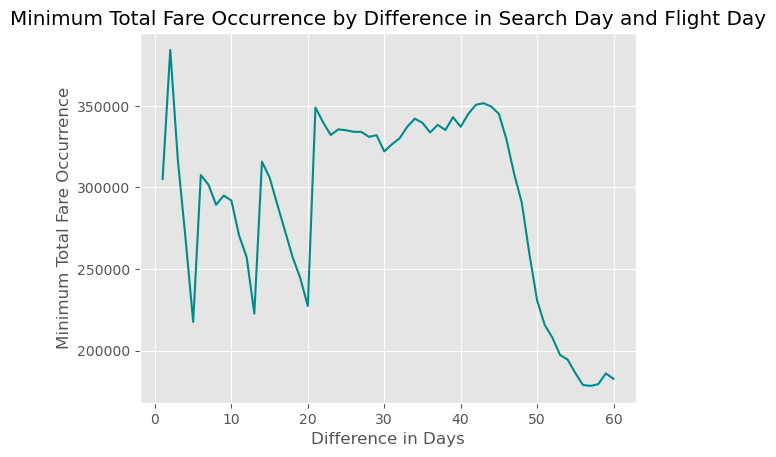

<Figure size 1000x600 with 0 Axes>

In [ ]:
# group by difference in days and count the occurrences of minimum totalFare for each group
df_counts = min_fares.groupBy('diff_days').count()

# find the min totalFare for each flight
window_spec = Window.partitionBy("legId")
minfare = minfare.withColumn("minTotalFare", F.min("totalFare").over(window_spec))

min_fare_points = minfare.filter(minfare.totalFare == minfare.minTotalFare) \
                           .groupBy("diff_days") \
                           .agg(F.count("*").alias("minTotalFareOccurrence")) \
                           .orderBy("diff_days")

# line plot
result_pd = min_fare_points.toPandas()
sns.lineplot(data=result_pd, x="diff_days", y="minTotalFareOccurrence", color='#008B8B')
plt.xlabel("Difference in Days")
plt.ylabel("Minimum Total Fare Occurrence")
plt.title("Minimum Total Fare Occurrence by Difference in Search Day and Flight Day")
plt.figure(figsize=(10, 6))
plt.show()

## 4.10 `oilPriceAvg`

### 4.10.1 How do average total fares and oil prices vary by month?

The graph reveals a correlation between flight fares and oil prices, showing similar trends. This may indicate a relationship between the two factors, with oil prices influencing flight fares. 

One possible reason is that oil is a crucial operation cost for airlines, as it is used to fuel their planes. When oil prices rise, airlines must pay more for fuel, increasing operating costs. To offset this, airlines may raise their fares to maintain profitability. Conversely, airlines may reduce their flight fare when oil prices fall as their operation costs decrease. Therefore, fluctuations in oil prices can have a significant impact on flight fares.

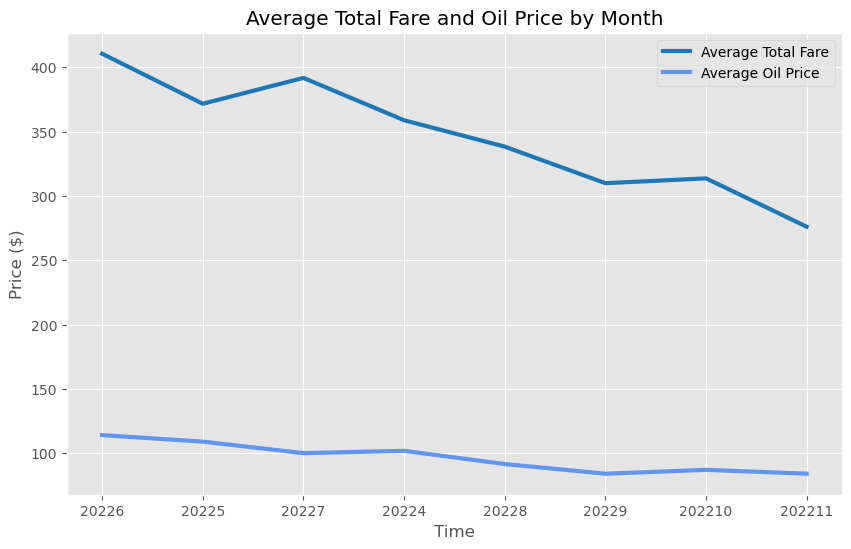

In [ ]:
# Aggregate the average total fare and oil price by month
fare_oil_df = df.groupby('yearMonth').agg(avg('totalFare').alias('Average Total Fare'), avg('oilPriceAvg').alias('Average Oil Price'))

# Convert the yearMonth column to a string
fare_oil_df = fare_oil_df.withColumn('yearMonth', fare_oil_df['yearMonth'].cast('string'))

# Plot the average fares and oil prices by month
fare_oil_df_pd = fare_oil_df.toPandas()
fare_oil_df_pd.plot(x='yearMonth', y=['Average Total Fare', 'Average Oil Price'], figsize=(10,6), color=['#1f77b4', '#6495ED'], linewidth=3)

plt.title('Average Total Fare and Oil Price by Month')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.show()

### 4.10.2 Oil Price History & Price Fluctuation Reasons

In Belle Davenport's article on February 25, 2021, it was reported that Libya's oil production slowed down due to war, resulting in a negative impact on the global oil supply in 2013. As seen in the chart below, 2013 had the highest average crude oil price. During 2016, "oil price dropped due to booming U.S. oil production, receding geopolitical concerns, and shifting OPEC policies". (by Word Bank)

In [ ]:
oil_clean = oil.na.drop()

In [ ]:
oil_price_year = oil_clean.groupBy(F.year("date").alias("year")) \
                              .agg(F.avg("value").alias("average_price"),
                                   F.max("value").alias("max_price"),
                                   F.min("value").alias("min_price")) \
                              .orderBy("year")

oil_price_year.show()

+----+------------------+---------+---------+
|year|     average_price|max_price|min_price|
+----+------------------+---------+---------+
|2013| 99.06126633165832|   110.53|   86.738|
|2014| 92.84993650793645|  106.916|    53.27|
|2015| 48.83480952380952|    61.43|   35.478|
|2016| 43.55950793650795|    54.06|    26.21|
|2017|50.886788844621485|    60.42|    42.53|
|2018| 64.88192063492066|    76.41|    42.53|
|2019|57.054023809523855|     66.3|    46.54|
|2020| 39.68385714285719|    63.27|   11.258|
|2021| 68.16995312500002|    84.65|    47.62|
|2022| 94.32243837209305|    123.7|    71.59|
|2023| 76.94381818181816|    81.62|    66.74|
+----+------------------+---------+---------+



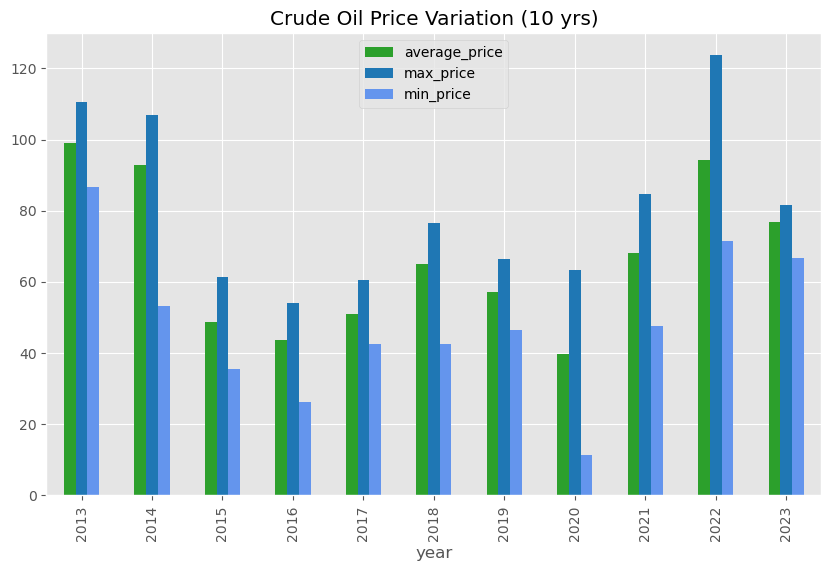

In [ ]:
oil_price_year_df = oil_price_year.toPandas()
oil_df = oil_price_year_df.set_index('year')

# Set the colors for the bar chart
colors = ["#2ca02c", "#1f77b4", "#6495ED"]

# Plot the bar chart for average, maximum, and minimum crude oil prices
oil_df[["average_price", "max_price","min_price"]].plot.bar(color=colors, figsize=(10, 6))

# Set the title for the plot
plt.title('Crude Oil Price Variation (10 yrs)')

# Show the plot
plt.show()

# 5. Summary of Insight from EDA

- LAX had the highest number of departures and arrivals between April and November 2022.
- The top 3 airports with the highest number of flight arrivals are LAX, LGA, and DFW.
- August and September have the most flights for both departures and arrivals.
- The minimum travel duration is 46 minutes, while most travel durations fall between 250 and 500 minutes.
- Only 15% of all tickets purchased between April and November 2022 were Basic Economy tickets.
- Non-stop flights make up 28% of the total, while flights with stops make up 72%.
- A positive correlation exists between flight distance and fares, with higher prices charged for longer flights.
- Flying out on Sunday is the most expensive date, while Tuesday and Wednesday are, on average, the cheapest for the actual flight date, and there is no significant difference in the day to search for and buy a ticket.
- There is a relationship between oil prices and flight fares, which might indicate that oil prices influence flight fares.

# 6. Featuring Engineering 

In the feature engineering phase, we aimed to extract features that are most relevant to our regression model. To achieve this, we created a new dataframe that included the `diffDays` feature, which is the difference in days between searchDate and flightDate. 

We also included the `flightMonth` and `flightDayOfWeek` features in our analysis, which represent the month and day of the week of the flightDate, respectively. These variables are important as flight prices can fluctuate depending on the time of year and day of the week, and incorporating them can improve the accuracy of our model's predictions.

After extracting these features, we removed columns that are not related to our regression model, such as `flightDate` and `searchDate`. Furthermore, we dropped the `isRefundable` column since most of its values were 'false' and provided limited explanatory power to the model.

In [ ]:
# select relevant columns from the original dataframe and create a new dataframe
new_df = df.select(['legId','flightDate','searchDate','startingAirport', 'destinationAirport', 'travelDurationMin', 'isBasicEconomy',
                    'isNonStop', 'baseFare', 'seatsRemaining', 'totalTravelDistance', 'yearMonth', 'oilPriceAvg'])

# calculate the difference in days between searchDate and flightDate and add it as a new column 'diffDays'
new_df = new_df.withColumn('diffDays', datediff(col('flightDate'), col('searchDate')))

# extract the month of the flightDate and add it as a new column 'flightMonth'
new_df = new_df.withColumn('flightMonth', month(col('flightDate')))

# extract the day of the week of the flightDate and add it as a new column 'flightDayOfWeek'
new_df = new_df.withColumn('flightDayOfWeek', dayofweek(col('flightDate')))

# drop 'yearMonth' and 'isRefundable' columns from the dataframesaaaaaaaaa  
new_df = new_df.drop('legID','yearMonth', 'isRefundable','flightDate','searchDate')

new_df = new_df.withColumn("flightMonth", col("flightMonth").cast("string"))
new_df = new_df.withColumn("flightDayOfWeek", col("flightDayOfWeek").cast("string"))

# show the first 3 rows of the new dataframe
new_df.show(3)

+---------------+------------------+-----------------+--------------+---------+--------+--------------+-------------------+------------------+--------+-----------+---------------+
|startingAirport|destinationAirport|travelDurationMin|isBasicEconomy|isNonStop|baseFare|seatsRemaining|totalTravelDistance|       oilPriceAvg|diffDays|flightMonth|flightDayOfWeek|
+---------------+------------------+-----------------+--------------+---------+--------+--------------+-------------------+------------------+--------+-----------+---------------+
|            ATL|               BOS|              149|         false|     true|  217.67|             9|              947.0|101.84057142857141|       1|          4|              1|
|            ATL|               BOS|              150|         false|     true|  217.67|             4|              947.0|101.84057142857141|       1|          4|              1|
|            ATL|               BOS|              150|         false|     true|  217.67|            

In [ ]:
new_df.printSchema()

root
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- travelDurationMin: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: double (nullable = true)
 |-- oilPriceAvg: double (nullable = true)
 |-- diffDays: integer (nullable = true)
 |-- flightMonth: string (nullable = true)
 |-- flightDayOfWeek: string (nullable = true)



In [ ]:
from pyspark.sql.functions import rand
from pyspark.ml.feature import RFormula

# Apply the formula to the sampled data
formula = RFormula(formula="baseFare ~ .")
model = formula.fit(new_df)
transformed = model.transform(new_df)

# Show the transformed data
transformed.select(['features','label']).show(3)

+--------------------+------+
|            features| label|
+--------------------+------+
|(50,[7,17,30,32,3...|217.67|
|(50,[7,17,30,32,3...|217.67|
|(50,[7,17,30,32,3...|217.67|
+--------------------+------+
only showing top 3 rows



After performing feature engineering, we ended up with a dataset that contains 50 features. We randomly split the entire dataset into training and test sets.

In [ ]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = transformed.randomSplit([0.7, 0.3],seed=42)

# 7. Model Fitting

## 7.1 Linear Regression

To begin with, we opted to use Linear Regression as a starting point for modeling. This is because it is a fundamental model that can help us better understand the relationship between the independent variables and the target variable, `baseFare`.

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Train a LinearRegression model.
lr = LinearRegression(featuresCol="features", labelCol="label")

# Train model.
model_lr = lr.fit(trainingData)

# Make predictions.
predictions_lr = model_lr.transform(testData)

# Select example rows to display.

predictions_lr.select("prediction", "label", "features").show(5)

23/04/24 17:33:31 WARN Instrumentation: [2d5d8292] regParam is zero, which might cause numerical instability and overfitting.
23/04/24 17:35:02 WARN Instrumentation: [2d5d8292] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


+------------------+------+--------------------+
|        prediction| label|            features|
+------------------+------+--------------------+
| 300.6499881279419|217.67|(50,[7,17,30,32,3...|
| 240.8381162406639|292.09|(50,[7,17,30,32,3...|
|228.25049773988883| 338.6|(50,[7,17,30,32,3...|
|217.85300871727767|357.21|(50,[7,17,30,32,3...|
|230.46960191515797|431.63|(50,[7,17,30,32,3...|
+------------------+------+--------------------+
only showing top 5 rows



In [ ]:
# Select (prediction, true label) and compute test error
evaluator_rmse = RegressionEvaluator(metricName="rmse")
evaluator_r2 = RegressionEvaluator(metricName="r2")

rmse_lr = evaluator_rmse.evaluate(predictions_lr)
r2_lr = evaluator_r2.evaluate(predictions_lr)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_lr)
print("R-squared (R2) on test data = %g" % r2_lr)

# Summary
print(model_lr)

Root Mean Squared Error (RMSE) on test data = 132.698
R-squared (R2) on test data = 0.465692
LinearRegressionModel: uid=LinearRegression_95144b3ed95b, numFeatures=50


## 7.2 Ridge Regression

We used Ridge Regression to further address multicollinearity issues in our dataset, and to prevent overfitting by adding a penalty term to the loss function.

In [ ]:
from pyspark.ml.regression import LinearRegression

# Train a Ridge Regression model.
rr = LinearRegression(featuresCol="features", labelCol="label", elasticNetParam=0.0, regParam=0.1)

# Train model.
model_rr = rr.fit(trainingData)

# Make predictions.
predictions_rr = model_rr.transform(testData)

# Select example rows to display.
predictions_rr.select("prediction", "label", "features").show(5)

+------------------+------+--------------------+
|        prediction| label|            features|
+------------------+------+--------------------+
| 300.6667850120955|217.67|(50,[7,17,30,32,3...|
| 241.1041708155393|292.09|(50,[7,17,30,32,3...|
|228.37651309845032| 338.6|(50,[7,17,30,32,3...|
| 218.1543154000716|357.21|(50,[7,17,30,32,3...|
| 230.7484776976975|431.63|(50,[7,17,30,32,3...|
+------------------+------+--------------------+
only showing top 5 rows



In [ ]:
rmse_rr = evaluator_rmse.evaluate(predictions_rr)
r2_rr = evaluator_r2.evaluate(predictions_rr)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_rr)
print("R-squared (R2) on test data = %g" % r2_rr)

# Summary
print(model_rr)

Root Mean Squared Error (RMSE) on test data = 132.699
R-squared (R2) on test data = 0.465685
LinearRegressionModel: uid=LinearRegression_5b43af379a9a, numFeatures=50


## 7.3 Lasso Regression

We used Lasso Regression to address concerns about multicollinearity in the dataset, and to improve the accuracy of our predictions through a regularization technique that shrinks data values towards a central point.

In [ ]:
# Train a Lasso Regression model.
lasso = LinearRegression(featuresCol="features", labelCol="label", elasticNetParam=1.0, regParam=0.1)

# Train model.
model_lasso = lasso.fit(trainingData)

# Make predictions.
predictions_lasso = model_lasso.transform(testData)

# Select example rows to display.
predictions_lasso.select("prediction", "label", "features").show(5)

+------------------+------+--------------------+
|        prediction| label|            features|
+------------------+------+--------------------+
| 298.6330051224455|217.67|(50,[7,17,30,32,3...|
| 241.0550314025432|292.09|(50,[7,17,30,32,3...|
|229.79746316218927| 338.6|(50,[7,17,30,32,3...|
| 218.5021873819425|357.21|(50,[7,17,30,32,3...|
|230.85373876884614|431.63|(50,[7,17,30,32,3...|
+------------------+------+--------------------+
only showing top 5 rows



In [ ]:
# Select (prediction, true label) and compute test error
evaluator_rmse = RegressionEvaluator(metricName="rmse")
evaluator_r2 = RegressionEvaluator(metricName="r2")

rmse_lasso = evaluator_rmse.evaluate(predictions_lasso)
r2_lasso = evaluator_r2.evaluate(predictions_lasso)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_lasso)
print("R-squared (R2) on test data = %g" % r2_lasso)

# Summary
print(model_lasso)

Root Mean Squared Error (RMSE) on test data = 132.734
R-squared (R2) on test data = 0.465402
LinearRegressionModel: uid=LinearRegression_1453067df9cd, numFeatures=50


##  7.4 Random Forest Regressor

We utilized Random Forest Regression due to its capability to handle non-linear relationships and outliers in the data, and its capacity to mitigate overfitting by averaging the results of multiple decision trees. However, the model's performance was comparatively lower than the other four models, indicating that the independent variables are more likely to have a linear relationship rather than a non-linear one.

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# Train a random forest regression model.
rf = RandomForestRegressor(featuresCol="features", labelCol="label", seed=42)

# Train model.
model_rf = rf.fit(trainingData)

# Make predictions.
predictions_rf = model_rf.transform(testData)

# Select example rows to display.
predictions_rf.select("prediction", "label", "features").show(5)

+------------------+------+--------------------+
|        prediction| label|            features|
+------------------+------+--------------------+
|227.48920065467252|217.67|(50,[7,17,30,32,3...|
|219.49816065516558|292.09|(50,[7,17,30,32,3...|
| 207.8329722479902| 338.6|(50,[7,17,30,32,3...|
|217.89300225636453|357.21|(50,[7,17,30,32,3...|
| 215.6885681687601|431.63|(50,[7,17,30,32,3...|
+------------------+------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(metricName="rmse")
evaluator_r2 = RegressionEvaluator(metricName="r2")

rmse_rf = evaluator_rmse.evaluate(predictions_rf)
r2_rf = evaluator_r2.evaluate(predictions_rf)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_rf)
print("R-squared (R2) on test data = %g" % r2_rf)

# Summary
print(model_rf)

Root Mean Squared Error (RMSE) on test data = 137.063
R-squared (R2) on test data = 0.429964
RandomForestRegressionModel: uid=RandomForestRegressor_36eaa888c3e8, numTrees=20, numFeatures=50


## 7.5 Gradient Boosted Tree Regression

Gradient Boosted Tree Regression is a powerful ensemble learning method that combines the strengths of both decision trees and boosting, enabling the model to learn complex relationships between the independent and dependent variables. 

Additionally, Gradient Boosted Tree Regression can handle outliers effectively, which can be a common issue in real-world datasets. The algorithm is also less susceptible to overfitting than other methods, such as Random Forest Regression, due to the use of gradient descent to minimize errors in the model. 

Therefore, we used Gradient Boosted Tree Regression to capture complex patterns and relationships in the data and predict the base fare of flights.

In [ ]:
from pyspark.ml.regression import GBTRegressor

# Train a gradient-boosted tree regression model.
gbt = GBTRegressor(featuresCol="features", labelCol="label", seed=42)

# Train model.
model_gbt = gbt.fit(trainingData)

# Make predictions.
predictions_gbt = model_gbt.transform(testData)

# Select example rows to display.
predictions_gbt.select("prediction", "label", "features").show(5)

+------------------+------+--------------------+
|        prediction| label|            features|
+------------------+------+--------------------+
| 273.4434568961909|217.67|(50,[7,17,30,32,3...|
|261.55553362774697|292.09|(50,[7,17,30,32,3...|
|215.85511238454208| 338.6|(50,[7,17,30,32,3...|
|  272.997191153509|357.21|(50,[7,17,30,32,3...|
|217.83753539211054|431.63|(50,[7,17,30,32,3...|
+------------------+------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(metricName="rmse")
evaluator_r2 = RegressionEvaluator(metricName="r2")

rmse_gbt = evaluator_rmse.evaluate(predictions_gbt)
r2_gbt = evaluator_r2.evaluate(predictions_gbt)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_gbt)
print("R-squared (R2) on test data = %g" % r2_gbt)

# Summary
print(model_gbt)

Root Mean Squared Error (RMSE) on test data = 129.173
R-squared (R2) on test data = 0.493701
GBTRegressionModel: uid=GBTRegressor_c9c1d508bd29, numTrees=20, numFeatures=50


# 8. Model Evaluation

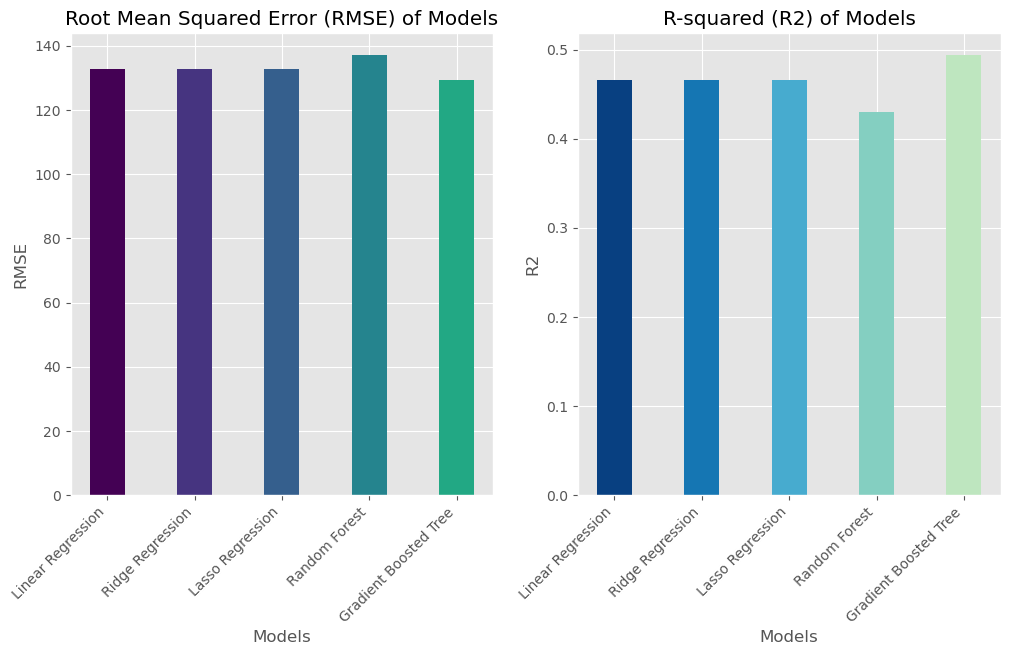

In [ ]:
import matplotlib.cm as cm

# Define the RMSE and R2 values for each model
# rmse_values = [rmse_lr, rmse_rr, rmse_lasso, rmse_rf, rmse_gbt]
# r2_values = [r2_lr, r2_rr, r2_lasso, r2_rf, r2_gbt]
rmse_values = [132.698, 132.699, 132.734, 137.063, 129.173]
r2_values = [0.465692, 0.465685, 0.465402, 0.429964, 0.493701]

# Define the names of the models
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest', 'Gradient Boosted Tree']

# Define the positions of the bars on the x-axis
x_pos = [i for i, _ in enumerate(models)]

# Create a figure and set the size
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))

#Plot the RMSE values as blue bars
ax1.bar(x_pos, rmse_values, color=plt.cm.viridis(np.linspace(0,0.6,len(models))), width=0.4)

# Add labels to the x-axis, y-axis, and the chart title
ax1.set_xlabel("Models")
ax1.set_ylabel("RMSE")
ax1.set_title("Root Mean Squared Error (RMSE) of Models")
ax1.set_xticks([i for i in x_pos])
ax1.set_xticklabels(models, rotation=45, ha="right")

# Plot the R2 values as green bars
ax2.bar(x_pos, r2_values, color=plt.cm.GnBu_r(np.linspace(0,0.7,len(models))), width=0.4)

# Add labels to the x-axis, y-axis, and the chart title
ax2.set_xlabel("Models")
ax2.set_ylabel("R2")
ax2.set_title("R-squared (R2) of Models")
ax2.set_xticks([i for i in x_pos])
ax2.set_xticklabels(models, rotation=45, ha="right")

# Adjust the padding between and within the plots
plt.subplots_adjust(wspace=0.2)

# Show the chart
plt.show()

The evaluation results show that the Gradient-boosted Tree model has the highest R-squared score and the lowest RMSE compared to other models. Therefore, we have decided to use this model as our "baseline" model for further tuning and optimization through grid search.

# 9. Fine-tuning Best Model with Grid Search

Considering the immense size of our dataset and the limited computational power of our cluster, performing a grid search on the complete dataset may lead to resource constraints and slow down the process. Therefore, we have decided to sample a subset of our data to perform the grid search.

By doing so, we can save memory and speed up the process without compromising the accuracy of our model. This approach will allow us to extract valuable insights from our data while also allowing us to tune our model's hyperparameters and optimize its performance.

However, sampling a subset of our data may potentially result in losing some vital information that could have been captured by using the complete dataset, which may have an impact on the overall accuracy of our model.

In [ ]:
from pyspark.sql.functions import rand
from pyspark.ml.feature import RFormula

# Define the fraction of data to keep
fraction = 0.001

# Randomly sample the data
sampled_df = new_df.sample(fraction=fraction, seed=42)

# Apply the formula to the sampled data
formula = RFormula(formula="baseFare ~ .")
model = formula.fit(sampled_df)
transformed2 = model.transform(sampled_df)

# Show the transformed data
transformed2.select(['features','label']).show(3)

+--------------------+------+
|            features| label|
+--------------------+------+
|(50,[1,17,30,33,3...|306.98|
|(50,[1,24,30,32,3...|213.95|
|(50,[1,28,30,33,3...|694.88|
+--------------------+------+
only showing top 3 rows



In [ ]:
# Split the data into training and test sets (30% held out for testing)
(trainingData2, testData2) = transformed2.randomSplit([0.7, 0.3],seed=42)

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator


# Define the GBTRegressor object.
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=20)

evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")


# Create a parameter grid builder.
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [4, 6])
             .addGrid(gbt.maxBins, [10, 20])
             .build())

# Create a cross-validator object.
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator_rmse, numFolds=2, seed=42)

# Train the model using the cross-validator.
model_gbt_cv = cv.fit(trainingData2)

# Make predictions.
predictions_gbt_cv = model_gbt_cv.transform(testData2)

# Best model
bestModel_gbt_cv = model_gbt_cv.bestModel

# Get the best model's RMSE and R2
predictions_best_gbt = bestModel_gbt_cv.transform(testData2)
rmse_best_gbt = evaluator_rmse.evaluate(predictions_best_gbt)
r2_best_gbt = evaluator_r2.evaluate(predictions_best_gbt)

print("Root Mean Squared Error (RMSE) of the best model = %g" % rmse_best_gbt)
print("R-squared (R2) of the best model = %g" % r2_best_gbt)

Root Mean Squared Error (RMSE) of the best model = 133.936
R-squared (R2) of the best model = 0.483856


In [ ]:
print(bestModel_gbt_cv)

GBTRegressionModel: uid=GBTRegressor_70b69949c61c, numTrees=20, numFeatures=50


In [ ]:
# Get the best model's parameters
best_params_gbt = bestModel_gbt_cv.extractParamMap()

# Print the parameters
print("Best model parameters: ")
for param in best_params_gbt:
    print("{}: {}".format(param.name, best_params_gbt[param]))

Best model parameters: 
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: all
featuresCol: features
impurity: variance
labelCol: label
leafCol: 
lossType: squared
maxBins: 10
maxDepth: 6
maxIter: 20
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
predictionCol: prediction
seed: -6682481135904123338
stepSize: 0.1
subsamplingRate: 1.0
validationTol: 0.01


Applying grid search didn't improve the model's performance much. Below are possible reasons:
- The default hyperparameters may already be well-suited for the data; thus, tweaking hyperparameters slightly may not make a noticeable difference.
- The wrong hyperparameters may have been selected for tuning, or the hyperparameters being tuned may not be very sensitive or relevant to the model's performance.
- The dataset may be relatively small since we only selected 0.1% of the entire dataset, making it challenging to discern slight differences in model performance.
- The grid search may have needed to be more comprehensive to cover the range of possible hyperparameter combinations that could lead to improved performance. Other methods, such as random search or feature selection, can be considered.

# 10. Feature Importance

In [ ]:
# Get feature columns
featureCols = pd.DataFrame(transformed.schema["features"].metadata["ml_attr"]["attrs"]["binary"] +
                           transformed.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")
featureCols = featureCols.set_index('idx')
featureCols.head()

,name
idx,
0,startingAirport_LAX
1,startingAirport_LGA
2,startingAirport_BOS
3,startingAirport_SFO
4,startingAirport_CLT


In [ ]:
# Get feature importances
importances = model_gbt.featureImportances

In [ ]:
# Create a pandas dataframe with feature names and importances
importances_df = pd.DataFrame({'feature': featureCols.name, 'importance': importances.toArray()})
importances_df.sort_values('importance', ascending=False, inplace=True)
importances_df.head()

,feature,importance
idx,,
34,totalTravelDistance,0.246488
31,isBasicEconomy,0.122683
30,travelDurationMin,0.108049
44,flightDayOfWeek_3,0.055013
35,oilPriceAvg,0.051895


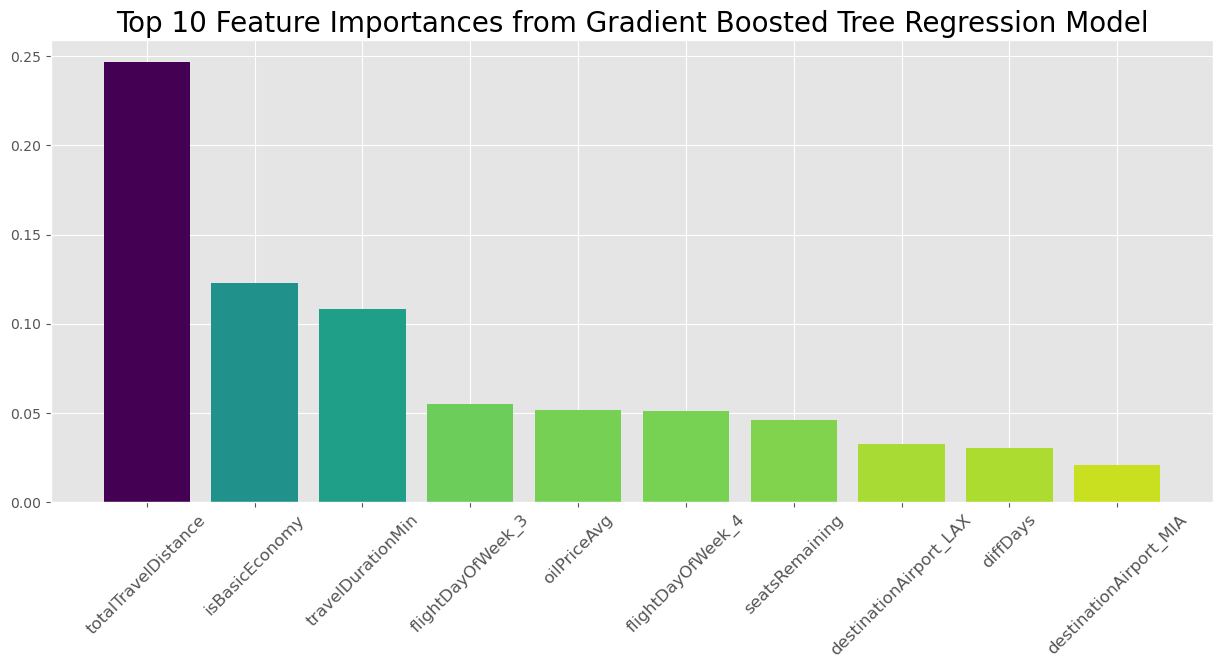

In [ ]:
import matplotlib.colors as colors
import matplotlib.cm as cm

# Plot the feature importances
plt.rcParams["figure.figsize"] = (15, 6)
plt.xticks(rotation=45, fontsize=12)
plt.bar(importances_df.feature[:10], importances_df.importance[:10], color=cm.viridis_r(importances_df.importance[:10] / importances_df.importance.max()))
plt.title('Top 10 Feature Importances from Gradient Boosted Tree Regression Model', fontsize=20)
plt.show()

Based on the analysis of feature importance, the model indicates that the most significant predictors of the target variable are:

- **totalTravelDistance**: This feature has the highest importance score, suggesting that it has the most decisive impact on the base fare of flight tickets. Longer travel distances may require more operation costs, such as fuel costs, resulting in a higher base fare of flight tickets.

- **isBasicEconomy**: This feature has the second-highest importance score, implying that whether a flight ticket is categorized as a basic economy may influence its price due to different pricing strategies implemented by airline companies.

- **travelDurationMin**: This feature is closely related to totalTravelDistance, indicating that longer flight durations may require more operation costs, such as fuel cost, resulting in a higher base fare of flight tickets.

- **oilPriceAvg**: This feature suggests that the monthly average price of oil may significantly impact the base fare of flight tickets, supporting our assumption that oil price can be a valuable predictor of the base fare of flight tickets.

1. **Price negotiation**: Traditional and online travel agencies can use the predicted ticket prices as a reference when negotiating with airlines or other ticket suppliers to secure better deals for their customers.
2. **Price alerts and promotions**: Both travel agencies and individual ticket purchasers can utilize the model to set up price alerts for specific routes and travel dates. When the predicted prices fall below a certain threshold, customers can be notified to take advantage of lower prices.
3. **Identifying pricing trends**: Since our model has features such as `flightMonth` (the month in which the flight takes place), `flightDayOfWeek` (the day of the week on which the flight takes place), and most importantly, the `diffDays` (the number of days between the current date and the departure date). We could try to predict the trends of the prices, which can help travel agencies and individual ticket purchasers identify pricing trends and patterns for specific routes and timeframes. This information can be used to make informed decisions about when to book flights to secure the best prices.
4. **Competitive analysis**: Travel agencies can use the model to compare predicted ticket prices across different airlines and identify opportunities for offering competitive prices or packages. This information can be used to attract more customers and gain a competitive edge in the market.
5. **Budget planning**: Individual ticket purchasers can use the model to estimate the cost of their flights, which can help them plan their travel budgets more effectively. This information can be especially useful for frequent travelers or those with flexible travel plans who wish to find the best deals.
6. **Revenue management**: By further analyzing the relationship between factors such as seats remaining and travel seasonality (`flightMonth` and `flightDayOfWeek`), airlines can better manage their seat inventory to maximize revenue. This can help them decide when to offer discounts or promotions to fill empty seats and when to increase prices to capitalize on high demand.
7. **Route planning and optimization**: The model can provide insights into the profitability of different routes based on factors such as starting and destination airports, travel distance, and the travel duration. Airlines can use this information to optimize their route networks and adjust flight frequencies to better serve their target markets.

8. **Oil cost management**: The model can help airlines understand the impact of oil price fluctuations on ticket prices. By analyzing the relationship between oil prices and ticket prices, airlines can develop better strategies to hedge against rising fuel costs or adjust their pricing strategies to maintain profitability.

- **External factors**: The model may not account for external factors that can impact flight ticket prices, such as geopolitical events, natural disasters, and changes in airline regulations or policies. These factors can cause fluctuations in ticket prices that the model may not capture.

- **Dynamic market conditions**: The airline industry constantly changes, with new competitors, routes, and technologies emerging regularly. As a result, the model may need to be frequently updated and retrained to maintain its accuracy and relevance.

# 11. Challenges

One of the significant challenges encountered during this project was the large size of the dataset. The size of the dataset created a substantial obstacle to achieving a balance between good model performance and efficient memory usage in the cluster. Despite efforts to optimize the code and cluster resources, the memory limitations persisted, and we could not run the grid search even after increasing the number of workers to 7.

We adopted a data reduction approach to tackle this challenge by randomly selecting a portion of the data to run the grid search. This enabled us to effectively test different combinations of parameters and observe their interaction while still conserving memory. This approach allowed us to arrive at a model that could still generalize well to new data despite the reduction in sample size.

Two challenges occurred when attempting to run the XGBoost. The first issue was insufficient computing memory, and the second involved the package installation for XGBoost. We put various parameters for XGBoost and tried different bins and parameters to obtain the best model. However, the current size of the cluster needs to be improved to support such a GridSearch base on a large dataset. Given the cost implications of maintaining a cost balance, we have decided to drop the XGBoost model

# 12. Conclusion

## 12.1 Possible Usages
1. **Price negotiation**: Traditional and online travel agencies can use the predicted ticket prices as a reference when negotiating with airlines or other ticket suppliers to secure better customer deals.
2. **Price alerts and promotions**: Both travel agencies and individual ticket purchasers can utilize the model to set up price alerts for specific routes and travel dates. When the predicted prices fall below a certain threshold, customers can be notified to take advantage of lower prices.
3. **Identifying pricing trends**: Since our model has features such as `flightMonth` (the month in which the flight takes place), `flightDayOfWeek` (the day of the week on which the flight takes place), and most importantly, the `diffDays` (the number of days between the current date and the departure date). We could predict the trends of the prices, which can help travel agencies and individual ticket purchasers identify pricing trends and patterns for specific routes and timeframes. This information can be used to decide when to book flights to secure the best prices.
4. **Competitive analysis**: Travel agencies can use the model to compare predicted ticket prices across different airlines and identify opportunities for offering competitive prices or packages. This information can be used to attract more customers and gain a competitive edge in the market.
5. **Budget planning**: Individual ticket purchasers can use the model to estimate the cost of their flights, which can help them plan their travel budgets more effectively. This information can benefit frequent travelers or those with flexible travel plans who wish to find the best deals.
6. **Revenue management**: By further analyzing the relationship between factors such as seats remaining and travel seasonality (`flightMonth` and `flightDayOfWeek`), airlines can better manage their seat inventory to maximize revenue. This can help them decide when to offer discounts or promotions to fill empty seats and when to increase prices to capitalize on high demand.
7. **Route planning and optimization**: The model can provide insights into the profitability of different routes based on factors such as starting and destination airports, travel distance, and the travel duration. Airlines can use this information to optimize their route networks and adjust flight frequencies to better serve their target markets.

8. **Oil cost management**: The model can help airlines understand the impact of oil price fluctuations on ticket prices. By analyzing the relationship between oil and ticket prices, airlines can develop better strategies to hedge against rising fuel costs or adjust their pricing strategies to maintain profitability.

## 12.2 Limitations of our model

1. **External factors**: The model may not account for external factors that can impact flight ticket prices, such as geopolitical events, natural disasters, and changes in airline regulations or policies. These factors can cause fluctuations in ticket prices that the model may not capture.

2. **Dynamic market conditions**: The airline industry is constantly changing, with new competitors, routes, and technologies emerging regularly. As a result, the model may need to be frequently updated and retrained to maintain its accuracy and relevance.

## 12.3 Suggestions

Today's primary factors influencing ticket prices are primarily driven by flight experiences and customer behaviors, followed by supply chain management factors such as oil prices. Within all variables airline company can take control. The airline company can increase revenue by either increasing the ticket quantity or investing in financial products of the crude oil - when the market price increase, the airline company can trade the excess inventory; or migrate the risk of Crude Oil Price fluctuations. 

According to the principle of supply and demand, individuals tend to accept the prevailing market price. An airline company can increase prices for customers who travel on Wednesdays, create a positive brand image by offering special discounted packages to frequent Wednesday flyers, or attract customers who fly on other days of the week. For now, offering special discounted packages, price promotions, or other specialized services are the best operation choices since we have yet to determine the causal influence between the day of the flight and the number of flyers. 

Even though we do not have a sufficient amount of data term to measure whether long for those long-distance flights with high prices will have high seating capacity, the airline company can maximize their revenue, or flyers can choose the flight route/connection best fit for them by optimizing the travel distance or adding connections during the trip. 

# References

- Data original source: https://www.expedia.com/ 
- Kaggle link for dataset: https://www.kaggle.com/datasets/dilwong/flightprices
- Tom B. Brown et al. (2020). Language Models are Few-Shot Learners. Proceedings of the 34th Conference on Neural Information Processing Systems (NeurIPS 2020) (https://proceedings.neurips.cc/paper/2020/file/1457c0d6bfcb4967418bfb8ac142f64a-Paper.pdf)
- ChatGPT for the duration_to_minutes function in 3.2
- Seaborn: Statistical Data Visualization (https://seaborn.pydata.org)
- CSS color names (https://www.w3.org/wiki/CSS/Properties/color/keywords)
- European Interest in Libyan Oil (https://channel16.dryadglobal.com/european-interest-in-libyan-oil)
- The Impact of the COVID-19 Pandemic on Food Price Indexes and Data Collection (https://www.bls.gov/opub/mlr/2020/article/the-impact-of-the-covid-19-pandemic-on-food-price-indexes-and-data-collection.htm#:~:text=After%20the%20onset%20of%20the,a%20plunge%20in%20oil%20prices)
- RFormula Documentation (https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.RFormula.html)
- ML Tuning: model selection and hyperparameter tuning (https://spark.apache.org/docs/latest/ml-tuning.html)
- ChiSqSelector documentation (https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.ChiSqSelector.html)
- How Airlines handle Oil Price volatiliy (https://www.investopedia.com/articles/investing/081415/4-ways-airlines-hedge-against-oil.asp)